# DSP Final Project (Model Training)
- Joheun Kang (N11691404)

GitHub Reference:  
1. https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer
2. https://github.com/mkosaka1/Speech_Emotion_Recognition

Data: 
 - RAVDNESS
 - TESS
 
This jupyter notebook will show

1. Data processing
2. Model training
3. Model result
4. Save model

**Idea is heavely depends on the above github pages, but the model in this project can predict more emotions than both reference repository. Also, the accuracy has improved.**

# Import Libraries

In [700]:

#Import data packages
import os
import sys
import glob
import numpy as np
import pandas as pd

#Import audio packages
import librosa
import librosa.display
from scipy.io import wavfile
import scipy.io.wavfile
import sys

#Import plotting packages
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import seaborn as sns

#Import Keras & Tensorflow packages
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

# Data 
- Data:
1. RAVDESS
2. TESS

__RAVDESS__ data will be in the folder called __"raw_data1"__ <br>
__TESS__    data will be in the folder called __"raw_data2"__ <br>

The both dataset is not provided in the reference githubs, so please use the data that I provided in the folder.

In [593]:
#data_list = os.listdir('raw_data1/')
RAVDESS_list = os.listdir('raw_data1/')
print("we have %s amount of data in raw_data folder in raw_data1" %len(RAVDESS_list))

we have 1441 amount of data in raw_data folder in raw_data1


## Create gender-emotion labels for data
- we are going to analyze 

1. neutral
2. calm
3. happy
4. sad
5. angry
6. fear
7. disgust
8. surprised

In [594]:
# Check samples of RAVDESS data name
print(RAVDESS_list[:5])
RAVDESS_list.remove('.DS_Store') # there was .DS_store data 

['03-01-06-01-02-02-02.wav', '03-01-05-01-02-01-16.wav', '03-01-08-01-01-01-14.wav', '03-01-06-01-02-02-16.wav', '03-01-05-01-02-01-02.wav']


In [595]:
#Build list with target variables for each file
RAVDESS_feeling_list=[]
for emotion_path in RAVDESS_list:
    print(emotion_path)
    if emotion_path[0]!='.':
        if emotion_path.split('-')[2] == '01':
            RAVDESS_feeling_list.append("neutral")
        elif emotion_path.split('-')[2] == '02':
            RAVDESS_feeling_list.append("calm")
        elif emotion_path.split('-')[2] == '03':
            RAVDESS_feeling_list.append("happy")
        elif emotion_path.split('-')[2] == '04':
            RAVDESS_feeling_list.append("sad")
        elif emotion_path.split('-')[2] == '05':
            RAVDESS_feeling_list.append("angry")
        elif emotion_path.split('-')[2] == '06':
            RAVDESS_feeling_list.append("fear")
        elif emotion_path.split('-')[2] == '07':
            RAVDESS_feeling_list.append("disgust")
        elif emotion_path.split('-')[2] == '08':
            RAVDESS_feeling_list.append("surprised")


03-01-06-01-02-02-02.wav
03-01-05-01-02-01-16.wav
03-01-08-01-01-01-14.wav
03-01-06-01-02-02-16.wav
03-01-05-01-02-01-02.wav
03-01-01-01-02-02-06.wav
03-01-02-01-02-01-12.wav
03-01-01-01-02-02-12.wav
03-01-02-01-02-01-06.wav
03-01-02-02-01-01-06.wav
03-01-02-02-01-01-12.wav
03-01-06-02-01-02-16.wav
03-01-05-02-01-01-02.wav
03-01-08-02-02-01-14.wav
03-01-06-02-01-02-02.wav
03-01-05-02-01-01-16.wav
03-01-05-01-01-01-22.wav
03-01-08-01-02-01-20.wav
03-01-06-01-01-02-22.wav
03-01-08-01-02-01-08.wav
03-01-08-02-01-01-08.wav
03-01-06-02-02-02-22.wav
03-01-08-02-01-01-20.wav
03-01-05-02-02-01-22.wav
03-01-03-01-01-02-06.wav
03-01-03-01-01-02-12.wav
03-01-04-01-01-02-02.wav
03-01-07-01-01-01-16.wav
03-01-04-01-01-02-16.wav
03-01-07-01-01-01-02.wav
03-01-04-02-02-02-16.wav
03-01-07-02-02-01-02.wav
03-01-04-02-02-02-02.wav
03-01-07-02-02-01-16.wav
03-01-03-02-02-02-12.wav
03-01-03-02-02-02-06.wav
03-01-07-01-02-01-22.wav
03-01-04-01-02-02-22.wav
03-01-04-02-01-02-22.wav
03-01-07-02-01-01-22.wav


In [596]:
print(len(feeling_list))

1440


In [597]:
labels = pd.DataFrame(feeling_list)

In [598]:
labels.shape

(1440, 1)

In [599]:
labels = labels.rename({0:'emotion'}, axis = 1)

In [600]:
labels.shape

(1440, 1)

In [601]:
labels

,emotion
0,fear
1,angry
2,surprised
3,fear
4,angry
...,...
1435,surprised
1436,calm
1437,calm
1438,surprised


## Display Distribution of Classes

             0
emotion       
angry      192
calm       192
disgust    192
fear       192
happy      192
neutral     96
sad        192
surprised  192


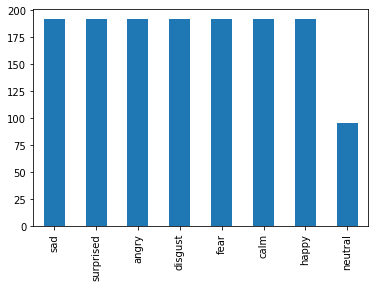

In [602]:
labels.emotion.value_counts().plot(kind= 'bar')
labels_total = pd.DataFrame(labels.groupby(['emotion']).size())
print(labels_total)

As we can see from the calss distrubution , we can see that there are __data imbalance__ might occurs from "neutral". So, __we will ignore "neutral" data for the model__.

# Configuration

In [603]:
# Librosa and MFCC Config

#sample feature
#librosa.core.load(path, sr=22050, mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>, res_type='kaiser_best')
res_type_s = 'kaiser_best'
duration_s = None
sample_rate_s = 22050
offset_s = 0.5

#Mfcc
#librosa.feature.mfcc(y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs)
mfcc_sample_rate = 22050
n_mfcc = 40
axis_mfcc = 1

In [604]:
ls

AudioData/
Audio_Speech_Actors/
Audio_Speech_Actors_01-24 (1).zip
DSP Lab - Project - Fall 2020.pdf
Data/
Emotion_Voice_Detection_Model.h5
amblock_output.wav
archive.zip
chorus_output.wav
dsp_final_JoheunKang.ipynb
dsp_project.ipynb
dsp_project_voice.wav
emotion_analyzer_final_project.json
emotion_analyzer_final_version.h5
emotion_capstone_final_dataframe_diego_rios.csv
emotion_capstone_final_tess_dataframe_diego_rios.csv
encoder.pkl
final.wav
final_results_gender_test.ipynb
h14JE.wav
model.json
output10.wav
raw_data1/
raw_data2/
su10KL.wav
test.py
y_train.pkl


In [605]:
print(data_list)

['03-01-06-01-02-02-02.wav', '03-01-05-01-02-01-16.wav', '03-01-08-01-01-01-14.wav', '03-01-06-01-02-02-16.wav', '03-01-05-01-02-01-02.wav', '03-01-01-01-02-02-06.wav', '03-01-02-01-02-01-12.wav', '03-01-01-01-02-02-12.wav', '03-01-02-01-02-01-06.wav', '03-01-02-02-01-01-06.wav', '03-01-02-02-01-01-12.wav', '03-01-06-02-01-02-16.wav', '03-01-05-02-01-01-02.wav', '03-01-08-02-02-01-14.wav', '03-01-06-02-01-02-02.wav', '03-01-05-02-01-01-16.wav', '03-01-05-01-01-01-22.wav', '03-01-08-01-02-01-20.wav', '03-01-06-01-01-02-22.wav', '03-01-08-01-02-01-08.wav', '03-01-08-02-01-01-08.wav', '03-01-06-02-02-02-22.wav', '03-01-08-02-01-01-20.wav', '03-01-05-02-02-01-22.wav', '03-01-03-01-01-02-06.wav', '03-01-03-01-01-02-12.wav', '03-01-04-01-01-02-02.wav', '03-01-07-01-01-01-16.wav', '03-01-04-01-01-02-16.wav', '03-01-07-01-01-01-02.wav', '03-01-04-02-02-02-16.wav', '03-01-07-02-02-01-02.wav', '03-01-04-02-02-02-02.wav', '03-01-07-02-02-01-16.wav', '03-01-03-02-02-02-12.wav', '03-01-03-02-02-02-

In [606]:
# Remove the .DS_Store file
data_list.remove('.DS_Store')

In [609]:
data_list

['03-01-06-01-02-02-02.wav',
 '03-01-05-01-02-01-16.wav',
 '03-01-08-01-01-01-14.wav',
 '03-01-06-01-02-02-16.wav',
 '03-01-05-01-02-01-02.wav',
 '03-01-01-01-02-02-06.wav',
 '03-01-02-01-02-01-12.wav',
 '03-01-01-01-02-02-12.wav',
 '03-01-02-01-02-01-06.wav',
 '03-01-02-02-01-01-06.wav',
 '03-01-02-02-01-01-12.wav',
 '03-01-06-02-01-02-16.wav',
 '03-01-05-02-01-01-02.wav',
 '03-01-08-02-02-01-14.wav',
 '03-01-06-02-01-02-02.wav',
 '03-01-05-02-01-01-16.wav',
 '03-01-05-01-01-01-22.wav',
 '03-01-08-01-02-01-20.wav',
 '03-01-06-01-01-02-22.wav',
 '03-01-08-01-02-01-08.wav',
 '03-01-08-02-01-01-08.wav',
 '03-01-06-02-02-02-22.wav',
 '03-01-08-02-01-01-20.wav',
 '03-01-05-02-02-01-22.wav',
 '03-01-03-01-01-02-06.wav',
 '03-01-03-01-01-02-12.wav',
 '03-01-04-01-01-02-02.wav',
 '03-01-07-01-01-01-16.wav',
 '03-01-04-01-01-02-16.wav',
 '03-01-07-01-01-01-02.wav',
 '03-01-04-02-02-02-16.wav',
 '03-01-07-02-02-01-02.wav',
 '03-01-04-02-02-02-02.wav',
 '03-01-07-02-02-01-16.wav',
 '03-01-03-02-

# Feature extraction

In [610]:
rawdata_ravdess = pd.DataFrame(columns=['feature'])
bookmark=0

for y in data_list:
    print("y:    ",y)
    X, sample_rate = librosa.load('raw_data1/'+y, res_type = 'kaiser_best',duration = None,sr = 22050,offset = 0.5)
    sample_rate = np.array(sample_rate)
    
    #Get MFCCs from each file
    mfccs = librosa.feature.mfcc(y=X,sr = mfcc_sample_rate,n_mfcc = n_mfcc)
    
    #Calculate mean of MFCCs
    mfccs_mean = np.mean(mfccs,axis = axis_mfcc)
    feature = mfccs_mean
    
    #Add MFCCs feature results to list
    rawdata_ravdess.loc[bookmark] = [feature]
    bookmark=bookmark+1

y:     03-01-06-01-02-02-02.wav
y:     03-01-05-01-02-01-16.wav
y:     03-01-08-01-01-01-14.wav
y:     03-01-06-01-02-02-16.wav
y:     03-01-05-01-02-01-02.wav
y:     03-01-01-01-02-02-06.wav
y:     03-01-02-01-02-01-12.wav
y:     03-01-01-01-02-02-12.wav
y:     03-01-02-01-02-01-06.wav
y:     03-01-02-02-01-01-06.wav
y:     03-01-02-02-01-01-12.wav
y:     03-01-06-02-01-02-16.wav
y:     03-01-05-02-01-01-02.wav
y:     03-01-08-02-02-01-14.wav
y:     03-01-06-02-01-02-02.wav
y:     03-01-05-02-01-01-16.wav
y:     03-01-05-01-01-01-22.wav
y:     03-01-08-01-02-01-20.wav
y:     03-01-06-01-01-02-22.wav
y:     03-01-08-01-02-01-08.wav
y:     03-01-08-02-01-01-08.wav
y:     03-01-06-02-02-02-22.wav
y:     03-01-08-02-01-01-20.wav
y:     03-01-05-02-02-01-22.wav
y:     03-01-03-01-01-02-06.wav
y:     03-01-03-01-01-02-12.wav
y:     03-01-04-01-01-02-02.wav
y:     03-01-07-01-01-01-16.wav
y:     03-01-04-01-01-02-16.wav
y:     03-01-07-01-01-01-02.wav
y:     03-01-04-02-02-02-16.wav
y:     0

y:     03-01-02-02-02-01-21.wav
y:     03-01-05-02-02-01-19.wav
y:     03-01-02-02-02-01-09.wav
y:     03-01-01-01-01-02-09.wav
y:     03-01-02-01-01-01-09.wav
y:     03-01-05-01-01-01-19.wav
y:     03-01-02-01-01-01-21.wav
y:     03-01-01-01-01-02-21.wav
y:     03-01-06-01-01-02-19.wav
y:     03-01-02-02-01-01-01.wav
y:     03-01-02-02-01-01-15.wav
y:     03-01-06-02-01-02-11.wav
y:     03-01-05-02-01-01-05.wav
y:     03-01-08-02-02-01-13.wav
y:     03-01-08-02-02-01-07.wav
y:     03-01-06-02-01-02-05.wav
y:     03-01-05-02-01-01-11.wav
y:     03-01-06-01-02-02-05.wav
y:     03-01-05-01-02-01-11.wav
y:     03-01-08-01-01-01-07.wav
y:     03-01-08-01-01-01-13.wav
y:     03-01-06-01-02-02-11.wav
y:     03-01-05-01-02-01-05.wav
y:     03-01-01-01-02-02-01.wav
y:     03-01-02-01-02-01-15.wav
y:     03-01-01-01-02-02-15.wav
y:     03-01-02-01-02-01-01.wav
y:     03-01-02-01-02-01-17.wav
y:     03-01-01-01-02-02-03.wav
y:     03-01-02-01-02-01-03.wav
y:     03-01-01-01-02-02-17.wav
y:     0

y:     03-01-08-01-01-02-18.wav
y:     03-01-01-01-02-01-22.wav
y:     03-01-02-02-02-02-02.wav
y:     03-01-02-02-02-02-16.wav
y:     03-01-05-02-02-02-06.wav
y:     03-01-06-02-02-01-12.wav
y:     03-01-08-02-01-02-10.wav
y:     03-01-08-02-01-02-04.wav
y:     03-01-05-02-02-02-12.wav
y:     03-01-06-02-02-01-06.wav
y:     03-01-05-01-01-02-12.wav
y:     03-01-06-01-01-01-06.wav
y:     03-01-08-01-02-02-04.wav
y:     03-01-08-01-02-02-10.wav
y:     03-01-05-01-01-02-06.wav
y:     03-01-06-01-01-01-12.wav
y:     03-01-02-01-01-02-16.wav
y:     03-01-01-01-01-01-02.wav
y:     03-01-02-01-01-02-02.wav
y:     03-01-01-01-01-01-16.wav
y:     03-01-05-01-01-02-02.wav
y:     03-01-06-01-01-01-16.wav
y:     03-01-08-01-02-02-14.wav
y:     03-01-05-01-01-02-16.wav
y:     03-01-06-01-01-01-02.wav
y:     03-01-02-01-01-02-06.wav
y:     03-01-01-01-01-01-12.wav
y:     03-01-02-01-01-02-12.wav
y:     03-01-01-01-01-01-06.wav
y:     03-01-02-02-02-02-12.wav
y:     03-01-02-02-02-02-06.wav
y:     0

y:     03-01-03-01-01-01-14.wav
y:     03-01-04-01-01-01-04.wav
y:     03-01-07-01-01-02-10.wav
y:     03-01-04-01-01-01-10.wav
y:     03-01-07-01-01-02-04.wav
y:     03-01-04-02-01-01-24.wav
y:     03-01-07-02-01-02-24.wav
y:     03-01-03-02-01-01-08.wav
y:     03-01-04-02-01-01-18.wav
y:     03-01-03-02-01-01-20.wav
y:     03-01-07-02-01-02-18.wav
y:     03-01-07-01-02-02-18.wav
y:     03-01-03-01-02-01-20.wav
y:     03-01-04-01-02-01-18.wav
y:     03-01-03-01-02-01-08.wav
y:     03-01-07-01-02-02-24.wav
y:     03-01-04-01-02-01-24.wav
y:     03-01-02-02-01-02-14.wav
y:     03-01-06-02-01-01-10.wav
y:     03-01-05-02-01-02-04.wav
y:     03-01-08-02-02-02-12.wav
y:     03-01-08-02-02-02-06.wav
y:     03-01-06-02-01-01-04.wav
y:     03-01-05-02-01-02-10.wav
y:     03-01-06-01-02-01-04.wav
y:     03-01-05-01-02-02-10.wav
y:     03-01-08-01-01-02-06.wav
y:     03-01-08-01-01-02-12.wav
y:     03-01-06-01-02-01-10.wav
y:     03-01-05-01-02-02-04.wav
y:     03-01-02-01-02-02-14.wav
y:     0

y:     03-01-04-02-02-01-15.wav
y:     03-01-07-02-02-02-15.wav
y:     03-01-04-02-02-01-01.wav
y:     03-01-07-01-01-02-15.wav
y:     03-01-04-01-01-01-01.wav
y:     03-01-07-01-01-02-01.wav
y:     03-01-04-01-01-01-15.wav
y:     03-01-03-01-01-01-05.wav
y:     03-01-03-01-01-01-11.wav
y:     03-01-07-02-01-02-09.wav
y:     03-01-04-02-01-01-09.wav
y:     03-01-03-02-01-01-19.wav
y:     03-01-04-02-01-01-21.wav
y:     03-01-07-02-01-02-21.wav
y:     03-01-07-01-02-02-21.wav
y:     03-01-04-01-02-01-21.wav
y:     03-01-03-01-02-01-19.wav
y:     03-01-04-01-02-01-09.wav
y:     03-01-07-01-02-02-09.wav
y:     03-01-08-02-02-02-17.wav
y:     03-01-05-02-01-02-01.wav
y:     03-01-06-02-01-01-15.wav
y:     03-01-05-02-01-02-15.wav
y:     03-01-06-02-01-01-01.wav
y:     03-01-08-02-02-02-03.wav
y:     03-01-02-02-01-02-05.wav
y:     03-01-02-02-01-02-11.wav
y:     03-01-02-01-02-02-11.wav
y:     03-01-01-01-02-01-05.wav
y:     03-01-02-01-02-02-05.wav
y:     03-01-01-01-02-01-11.wav
y:     0

y:     03-01-05-02-02-01-05.wav
y:     03-01-06-02-02-02-05.wav
y:     03-01-05-02-02-01-11.wav
y:     03-01-08-02-01-01-07.wav
y:     03-01-02-02-02-01-01.wav
y:     03-01-02-02-02-01-15.wav
y:     03-01-03-01-01-02-09.wav
y:     03-01-07-01-01-01-19.wav
y:     03-01-03-01-01-02-21.wav
y:     03-01-04-01-01-02-19.wav
y:     03-01-04-02-02-02-19.wav
y:     03-01-03-02-02-02-21.wav
y:     03-01-07-02-02-01-19.wav
y:     03-01-03-02-02-02-09.wav
y:     03-01-04-01-02-02-05.wav
y:     03-01-07-01-02-01-11.wav
y:     03-01-04-01-02-02-11.wav
y:     03-01-07-01-02-01-05.wav
y:     03-01-03-01-02-02-01.wav
y:     03-01-03-01-02-02-15.wav
y:     03-01-03-02-01-02-15.wav
y:     03-01-03-02-01-02-01.wav
y:     03-01-04-02-01-02-11.wav
y:     03-01-07-02-01-01-05.wav
y:     03-01-04-02-01-02-05.wav
y:     03-01-07-02-01-01-11.wav
y:     03-01-07-02-01-01-10.wav
y:     03-01-04-02-01-02-04.wav
y:     03-01-07-02-01-01-04.wav
y:     03-01-04-02-01-02-10.wav
y:     03-01-03-02-01-02-14.wav
y:     0

In [611]:
rawdata_ravdess.shape


(1440, 1)

In [612]:
rawdata_ravdess.isnull().values.any()


False

In [613]:
rawdata_ravdess

,feature
0,"[-542.7508, 33.47142, -31.427399, -0.69883484,..."
1,"[-517.40607, 39.505806, -4.702804, 4.0109878, ..."
2,"[-663.42773, 45.332085, -7.222, 8.643623, -12...."
3,"[-525.9029, 43.364105, -7.143904, 5.685199, -2..."
4,"[-541.3278, 52.85218, -11.981932, 5.1141143, -..."
...,...
1435,"[-568.8316, 79.40551, 4.6348505, 17.796598, 0...."
1436,"[-637.70215, 72.05483, 1.3777567, 10.133444, 9..."
1437,"[-635.9385, 61.79729, -1.4246757, 9.095549, 7...."
1438,"[-634.49445, 78.67387, 6.42173, 17.673084, 4.3..."


In [614]:
#Turn array into dataframe
rawdata_ravdess_final = pd.DataFrame(rawdata_ravdess['feature'].values.tolist())

In [615]:
rawdata_ravdess_final.shape


(1440, 40)

In [616]:
# Check data sample
rawdata_ravdess_final.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-542.750793,33.471420,-31.427399,-0.698835,-11.833806,-11.753671,-14.535997,-20.404123,-6.519468,-4.652641,...,-5.802157,0.479940,-2.102547,-2.380357,-2.423682,-1.809657,-4.251172,2.055910,0.311751,3.795124
1,-517.406067,39.505806,-4.702804,4.010988,-11.723780,-6.276075,-10.151718,-12.701136,-13.851486,-0.955932,...,3.900952,4.570149,-0.961010,1.434237,-0.563856,3.619978,0.313168,2.668658,-1.350849,2.853959
2,-663.427734,45.332085,-7.222000,8.643623,-12.827558,-6.495750,-8.222808,-8.780598,-4.526157,-6.095737,...,-2.117719,1.539637,-2.428580,1.128651,-0.491584,1.573078,-0.171527,1.665220,1.014980,2.656616
3,-525.902893,43.364105,-7.143904,5.685199,-2.604740,-10.495439,-17.199978,-16.023638,-10.076735,1.249769,...,-0.698873,0.895134,-1.631093,1.067381,-1.492563,1.658710,-0.599985,1.912519,-0.663735,1.134584
4,-541.327820,52.852180,-11.981932,5.114114,-10.169215,-3.797928,-6.536666,-12.264288,-6.996627,-1.947820,...,0.499887,3.075699,0.249350,2.587077,1.202344,2.492644,-0.087768,1.232538,-0.983557,-1.481939


# Combine Features and Target ( RAVNESS)

In [617]:
#Join labels with features
newdf_ravdess = pd.concat([rawdata_ravdess_final,labels], axis=1)


In [618]:
#Rename dataframe
newdf_ravdess = newdf_ravdess.rename(index=str, columns={"0": "label"})

In [619]:
#Analyze dataframe shape
newdf_ravdess.shape

(1440, 41)

In [620]:
#Anayze dataframe sample
newdf_ravdess.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-542.750793,33.471420,-31.427399,-0.698835,-11.833806,-11.753671,-14.535997,-20.404123,-6.519468,-4.652641,...,0.479940,-2.102547,-2.380357,-2.423682,-1.809657,-4.251172,2.055910,0.311751,3.795124,fear
1,-517.406067,39.505806,-4.702804,4.010988,-11.723780,-6.276075,-10.151718,-12.701136,-13.851486,-0.955932,...,4.570149,-0.961010,1.434237,-0.563856,3.619978,0.313168,2.668658,-1.350849,2.853959,angry
2,-663.427734,45.332085,-7.222000,8.643623,-12.827558,-6.495750,-8.222808,-8.780598,-4.526157,-6.095737,...,1.539637,-2.428580,1.128651,-0.491584,1.573078,-0.171527,1.665220,1.014980,2.656616,surprised
3,-525.902893,43.364105,-7.143904,5.685199,-2.604740,-10.495439,-17.199978,-16.023638,-10.076735,1.249769,...,0.895134,-1.631093,1.067381,-1.492563,1.658710,-0.599985,1.912519,-0.663735,1.134584,fear
4,-541.327820,52.852180,-11.981932,5.114114,-10.169215,-3.797928,-6.536666,-12.264288,-6.996627,-1.947820,...,3.075699,0.249350,2.587077,1.202344,2.492644,-0.087768,1.232538,-0.983557,-1.481939,angry


In [621]:
#Datafram drop Nan values
newdf_ravdess.dropna(inplace=True)

In [622]:
X = df3.values

In [623]:

from sklearn.utils import shuffle

#Shuffle dataframe
newdf_ravdess = shuffle(newdf_ravdess)
newdf_ravdess.head(10)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
173,-354.176575,35.597641,-35.627823,-2.956707,-24.713802,-17.796621,-5.151159,-16.118509,-7.865614,-4.900944,...,0.438814,-1.185883,1.292630,-0.922105,1.303779,-0.552910,-0.495888,-1.716595,2.386196,angry
236,-465.852295,81.323265,-21.013294,3.964963,9.043668,-17.206673,-19.768448,-7.452659,-20.079098,-5.008074,...,1.416071,0.798417,4.305758,5.487063,5.888922,1.709574,0.668001,0.921873,1.736876,happy
1422,-573.186340,45.121197,8.497856,11.964556,-3.042205,-3.391483,-4.419545,-7.246663,-5.539496,-5.505269,...,2.734271,0.178521,4.082490,3.123958,4.947493,0.857533,1.675048,1.485398,2.964810,surprised
122,-495.683411,50.270596,10.149227,-0.229607,-8.817274,1.094214,-14.098309,-17.689375,-6.693050,-9.400161,...,0.919443,-3.559710,1.354119,-0.938903,2.712591,0.451897,2.253393,0.075782,1.481759,disgust
281,-593.575500,86.025543,-0.631018,18.079523,9.910287,1.127122,0.175112,-2.990120,-3.167777,-1.121648,...,1.023154,-0.651416,0.152181,0.414341,3.354547,1.013163,2.952692,-2.378881,-0.277771,calm
1100,-434.508789,53.835598,-11.931460,9.348625,5.906302,-4.469250,1.746096,-0.631310,-14.519789,2.265842,...,1.491116,1.933954,5.567080,3.943010,4.013314,2.298357,2.186610,2.655824,4.551471,angry
1055,-771.101501,67.058365,16.439064,23.911251,7.902646,5.475070,-0.537156,-0.911656,3.548046,7.690874,...,0.147628,-1.317811,0.551408,0.092703,1.651613,-1.349867,-2.323860,-2.662338,0.177693,calm
1303,-671.989197,65.398598,24.830141,20.885220,8.793779,8.032567,4.441080,2.260435,-4.748837,-0.247606,...,1.615473,-0.684113,1.263663,-2.797892,0.771418,-2.696944,-1.126668,-2.775580,0.070211,sad
53,-625.762024,85.657501,1.225036,12.292361,8.364403,-0.181586,-12.111747,-5.036881,-2.492383,-6.481968,...,-0.361029,-3.019603,-1.465412,-1.333859,0.163687,-2.475883,-1.011360,-1.214094,0.458598,sad
1147,-658.287903,66.162811,-2.807346,12.958468,2.431641,-3.896729,-2.707870,-9.451134,-10.880826,0.076181,...,2.823899,1.785627,7.565262,6.395666,7.726189,6.218607,6.808975,4.070140,1.776481,neutral


In [624]:
#Verify that there are no null values
newdf_ravdess.isnull().values.any()

False

In [625]:
# Check dataframe sample
newdf_ravdess.head(5)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
173,-354.176575,35.597641,-35.627823,-2.956707,-24.713802,-17.796621,-5.151159,-16.118509,-7.865614,-4.900944,...,0.438814,-1.185883,1.292630,-0.922105,1.303779,-0.552910,-0.495888,-1.716595,2.386196,angry
236,-465.852295,81.323265,-21.013294,3.964963,9.043668,-17.206673,-19.768448,-7.452659,-20.079098,-5.008074,...,1.416071,0.798417,4.305758,5.487063,5.888922,1.709574,0.668001,0.921873,1.736876,happy
1422,-573.186340,45.121197,8.497856,11.964556,-3.042205,-3.391483,-4.419545,-7.246663,-5.539496,-5.505269,...,2.734271,0.178521,4.082490,3.123958,4.947493,0.857533,1.675048,1.485398,2.964810,surprised
122,-495.683411,50.270596,10.149227,-0.229607,-8.817274,1.094214,-14.098309,-17.689375,-6.693050,-9.400161,...,0.919443,-3.559710,1.354119,-0.938903,2.712591,0.451897,2.253393,0.075782,1.481759,disgust
281,-593.575500,86.025543,-0.631018,18.079523,9.910287,1.127122,0.175112,-2.990120,-3.167777,-1.121648,...,1.023154,-0.651416,0.152181,0.414341,3.354547,1.013163,2.952692,-2.378881,-0.277771,calm


In [626]:
#Analyz shape of dataframe
newdf_ravdess.shape

(1440, 41)

In [627]:
# see number of emotions
newdf_ravdess[newdf_ravdess.columns[-1]].nunique()

8

# TESS Dataset

In [629]:
# Build list of audio files
folder_list_tess = os.listdir('raw_data2/')
folder_list_tess


['d15KL.wav',
 'n03JE.wav',
 'f05JE.wav',
 'd15DC.wav',
 'f09KL.wav',
 'n29JK.wav',
 'a02JK.wav',
 'f09DC.wav',
 'sa11DC.wav',
 'n14JK.wav',
 'f12JK.wav',
 'sa11KL.wav',
 'h02KL.wav',
 'a15JE.wav',
 'h02DC.wav',
 'n30JK.wav',
 'su15DC.wav',
 'n16KL.wav',
 'f10KL.wav',
 'sa13JK.wav',
 'n16DC.wav',
 'su15KL.wav',
 'f10DC.wav',
 'n27JE.wav',
 'sa04JE.wav',
 'sa08DC.wav',
 'sa08KL.wav',
 'd15JK.wav',
 'n25JE.wav',
 'sa06JE.wav',
 'f09JK.wav',
 'n29KL.wav',
 'h15JE.wav',
 'a02KL.wav',
 'a02DC.wav',
 'n29DC.wav',
 'd02JE.wav',
 'n14DC.wav',
 'f12DC.wav',
 'n14KL.wav',
 'f12KL.wav',
 'sa11JK.wav',
 'n18JE.wav',
 'h02JK.wav',
 'n16JK.wav',
 'n30KL.wav',
 'f10JK.wav',
 'sa13KL.wav',
 'su15JK.wav',
 'n30DC.wav',
 'sa13DC.wav',
 'n01JE.wav',
 'f07JE.wav',
 'su02JE.wav',
 'sa08JK.wav',
 'h04KL.wav',
 'a13JE.wav',
 'h04DC.wav',
 'd08JK.wav',
 'su11JK.wav',
 'h08JE.wav',
 'n12JK.wav',
 'f14JK.wav',
 'a04JK.wav',
 'n09KL.wav',
 'n09DC.wav',
 'su06JE.wav',
 '.DS_Store',
 'd13KL.wav',
 'd13DC.wav',
 'n

# TESS Get emotion features

In [630]:
feeling_list_tess = []

#'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad' and 'surprised' emotion classes respectively. 
#E.g., 'd03.wav' is the 3rd disgust sentence.  

emotion_dic = {"a":'angry', 
               "d":'disgust', 
               "f":'fear', 
               "h":'happy', 
               "n":'neutral', 
               "sa":'sad', 
               "su":'surprised'}

In [631]:
folder_list_tess.remove('.DS_Store')

In [632]:
for file in folder_list_tess:
    print(file)
    file_name = file.split(".")[0] 
    emotion = file_name[:-4]
    feeling_list_tess.append(emotion_dic[emotion])

#Verify emotions
feeling_list_tess

d15KL.wav
n03JE.wav
f05JE.wav
d15DC.wav
f09KL.wav
n29JK.wav
a02JK.wav
f09DC.wav
sa11DC.wav
n14JK.wav
f12JK.wav
sa11KL.wav
h02KL.wav
a15JE.wav
h02DC.wav
n30JK.wav
su15DC.wav
n16KL.wav
f10KL.wav
sa13JK.wav
n16DC.wav
su15KL.wav
f10DC.wav
n27JE.wav
sa04JE.wav
sa08DC.wav
sa08KL.wav
d15JK.wav
n25JE.wav
sa06JE.wav
f09JK.wav
n29KL.wav
h15JE.wav
a02KL.wav
a02DC.wav
n29DC.wav
d02JE.wav
n14DC.wav
f12DC.wav
n14KL.wav
f12KL.wav
sa11JK.wav
n18JE.wav
h02JK.wav
n16JK.wav
n30KL.wav
f10JK.wav
sa13KL.wav
su15JK.wav
n30DC.wav
sa13DC.wav
n01JE.wav
f07JE.wav
su02JE.wav
sa08JK.wav
h04KL.wav
a13JE.wav
h04DC.wav
d08JK.wav
su11JK.wav
h08JE.wav
n12JK.wav
f14JK.wav
a04JK.wav
n09KL.wav
n09DC.wav
su06JE.wav
d13KL.wav
d13DC.wav
n05JE.wav
f03JE.wav
a06DC.wav
su08JK.wav
h11JE.wav
a06KL.wav
n21JE.wav
sa02JE.wav
d11JK.wav
h06JK.wav
su13DC.wav
n10KL.wav
sa15JK.wav
d06JE.wav
n10DC.wav
su13KL.wav
h04JK.wav
d08DC.wav
d08KL.wav
n12DC.wav
su11KL.wav
f14DC.wav
d04JE.wav
su11DC.wav
n12KL.wav
f14KL.wav
h13JE.wav
a04KL.wav
n09JK.

['disgust',
 'neutral',
 'fear',
 'disgust',
 'fear',
 'neutral',
 'angry',
 'fear',
 'sad',
 'neutral',
 'fear',
 'sad',
 'happy',
 'angry',
 'happy',
 'neutral',
 'surprised',
 'neutral',
 'fear',
 'sad',
 'neutral',
 'surprised',
 'fear',
 'neutral',
 'sad',
 'sad',
 'sad',
 'disgust',
 'neutral',
 'sad',
 'fear',
 'neutral',
 'happy',
 'angry',
 'angry',
 'neutral',
 'disgust',
 'neutral',
 'fear',
 'neutral',
 'fear',
 'sad',
 'neutral',
 'happy',
 'neutral',
 'neutral',
 'fear',
 'sad',
 'surprised',
 'neutral',
 'sad',
 'neutral',
 'fear',
 'surprised',
 'sad',
 'happy',
 'angry',
 'happy',
 'disgust',
 'surprised',
 'happy',
 'neutral',
 'fear',
 'angry',
 'neutral',
 'neutral',
 'surprised',
 'disgust',
 'disgust',
 'neutral',
 'fear',
 'angry',
 'surprised',
 'happy',
 'angry',
 'neutral',
 'sad',
 'disgust',
 'happy',
 'surprised',
 'neutral',
 'sad',
 'disgust',
 'neutral',
 'surprised',
 'happy',
 'disgust',
 'disgust',
 'neutral',
 'surprised',
 'fear',
 'disgust',
 'surp

In [634]:
#Build dataframe from array
labels_tess = pd.DataFrame(feeling_list_tess)
labels_tess.head()

In [636]:
#Rename column to emotion
labels_tess = labels_tess.rename({0: 'emotion'}, axis=1)

In [637]:

#Check shape
labels_tess.shape

(480, 1)

In [638]:
#Check results
labels_tess.head()

,emotion
0,disgust
1,neutral
2,fear
3,disgust
4,fear


In [639]:
#Check emotion size
labels_tess_total = pd.DataFrame(labels_tess.groupby(['emotion']).size())
labels_tess_total

,0
emotion,
angry,60
disgust,60
fear,60
happy,60
neutral,120
sad,60
surprised,60


# Extract features for TESS

In [640]:
folder_list_tess

['d15KL.wav',
 'n03JE.wav',
 'f05JE.wav',
 'd15DC.wav',
 'f09KL.wav',
 'n29JK.wav',
 'a02JK.wav',
 'f09DC.wav',
 'sa11DC.wav',
 'n14JK.wav',
 'f12JK.wav',
 'sa11KL.wav',
 'h02KL.wav',
 'a15JE.wav',
 'h02DC.wav',
 'n30JK.wav',
 'su15DC.wav',
 'n16KL.wav',
 'f10KL.wav',
 'sa13JK.wav',
 'n16DC.wav',
 'su15KL.wav',
 'f10DC.wav',
 'n27JE.wav',
 'sa04JE.wav',
 'sa08DC.wav',
 'sa08KL.wav',
 'd15JK.wav',
 'n25JE.wav',
 'sa06JE.wav',
 'f09JK.wav',
 'n29KL.wav',
 'h15JE.wav',
 'a02KL.wav',
 'a02DC.wav',
 'n29DC.wav',
 'd02JE.wav',
 'n14DC.wav',
 'f12DC.wav',
 'n14KL.wav',
 'f12KL.wav',
 'sa11JK.wav',
 'n18JE.wav',
 'h02JK.wav',
 'n16JK.wav',
 'n30KL.wav',
 'f10JK.wav',
 'sa13KL.wav',
 'su15JK.wav',
 'n30DC.wav',
 'sa13DC.wav',
 'n01JE.wav',
 'f07JE.wav',
 'su02JE.wav',
 'sa08JK.wav',
 'h04KL.wav',
 'a13JE.wav',
 'h04DC.wav',
 'd08JK.wav',
 'su11JK.wav',
 'h08JE.wav',
 'n12JK.wav',
 'f14JK.wav',
 'a04JK.wav',
 'n09KL.wav',
 'n09DC.wav',
 'su06JE.wav',
 'd13KL.wav',
 'd13DC.wav',
 'n05JE.wav',
 'f

In [642]:
rawdata_tess = pd.DataFrame(columns=['feature'])
bookmark=0

for y in folder_list_tess:
    #Get audio features
    X, sample_rate = librosa.load('raw_data2/'+y, 
                                  res_type = res_type_s,
                                  duration = duration_s,
                                  sr = sample_rate_s,
                                  offset=offset_s)
    
    #Get MFFC features
    mfccs = librosa.feature.mfcc(   y=X, 
                                    sr = mfcc_sample_rate, 
                                    n_mfcc = n_mfcc)
    #Get MFFCs average features
    mfccs_mean = np.mean(    mfccs, 
                             axis = axis_mfcc)
    feature = mfccs_mean
    rawdata_tess.loc[bookmark] = [feature]
    bookmark=bookmark+1

In [643]:
#Verify Tess features shape
rawdata_tess.shape


(480, 1)

In [644]:

#Check that there are no nan values
rawdata_tess.isnull().values.any()

False

In [645]:
#Get sample data
rawdata_tess.head()

,feature
0,"[-604.17444, 147.01393, 35.672474, 31.965645, ..."
1,"[-433.34634, 136.78377, 30.061651, 38.943287, ..."
2,"[-302.289, 87.939415, 12.370295, 23.428274, -1..."
3,"[-351.3222, 125.517265, 27.84602, 36.118633, 2..."
4,"[-566.8137, 135.1233, 7.1321716, 35.24064, 10...."


In [646]:

#Build list
rawdata_tess_final = pd.DataFrame(rawdata_tess['feature'].values.tolist())

In [647]:

#Check dataframe
rawdata_tess_final

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-604.174438,147.013931,35.672474,31.965645,7.140328,-8.043900,-11.735164,-2.694147,-8.815265,-13.027687,...,0.353470,-1.449076,-0.986787,1.352096,-0.312128,-2.993065,-0.226662,1.106439,-1.506400,-2.447976
1,-433.346344,136.783768,30.061651,38.943287,16.164078,-7.975110,-11.239890,-1.383186,-1.280454,0.040629,...,0.565352,1.241465,-3.291409,0.126060,1.311783,-1.462929,-0.195663,-0.398276,-1.187071,3.097876
2,-302.289001,87.939415,12.370295,23.428274,-17.248516,-2.726666,-29.626976,-14.062306,-12.230440,-4.792106,...,1.379714,4.937100,4.401528,0.578973,1.842953,1.546215,1.699168,2.532532,2.999504,3.182947
3,-351.322205,125.517265,27.846020,36.118633,21.740288,-0.764227,-25.205984,-2.931540,-0.362929,-15.643375,...,-1.019496,-0.857954,-1.976961,-1.741062,-1.571093,-0.244729,0.944246,1.540976,3.120263,2.626556
4,-566.813721,135.123306,7.132172,35.240639,10.290214,-5.227325,-12.139035,-4.018661,-17.000492,-16.189602,...,-2.830208,1.903659,-0.247034,-2.908133,3.014812,-0.843363,0.482764,2.149385,-0.076396,2.347629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-362.553406,151.945801,14.502989,48.835266,-2.132725,-21.459703,3.584512,0.701372,-10.616497,0.255622,...,0.948101,2.205760,1.991209,0.822536,-0.674983,0.678039,3.501161,4.684970,4.762434,1.705626
476,-658.006226,139.743042,26.277037,37.136322,16.856010,3.498728,-10.072317,0.686020,-0.329356,-5.025523,...,-0.060208,-1.341944,-2.575093,-4.122838,-0.460087,1.756860,-0.255574,-1.194099,-1.982112,-0.408159
477,-289.780670,107.382530,11.509796,30.353842,-0.981811,-0.136323,-32.080021,-6.593827,-5.672666,-23.600767,...,17.708963,9.857531,2.047608,-0.378327,3.690489,6.608534,5.489237,0.613812,-1.744214,1.451698
478,-432.543793,140.243866,22.230997,27.884289,30.496593,-6.149958,-18.127346,7.432833,2.646843,-10.302066,...,-0.195096,0.428502,-0.573654,0.451728,-0.216971,-0.634378,1.828223,2.337776,1.890718,1.447116


# Combine TESS features with labels

In [648]:
#Concat both feature table and target table
newdf_tess = pd.concat([rawdata_tess_final,labels_tess], axis=1)
newdf_tess

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-604.174438,147.013931,35.672474,31.965645,7.140328,-8.043900,-11.735164,-2.694147,-8.815265,-13.027687,...,-1.449076,-0.986787,1.352096,-0.312128,-2.993065,-0.226662,1.106439,-1.506400,-2.447976,disgust
1,-433.346344,136.783768,30.061651,38.943287,16.164078,-7.975110,-11.239890,-1.383186,-1.280454,0.040629,...,1.241465,-3.291409,0.126060,1.311783,-1.462929,-0.195663,-0.398276,-1.187071,3.097876,neutral
2,-302.289001,87.939415,12.370295,23.428274,-17.248516,-2.726666,-29.626976,-14.062306,-12.230440,-4.792106,...,4.937100,4.401528,0.578973,1.842953,1.546215,1.699168,2.532532,2.999504,3.182947,fear
3,-351.322205,125.517265,27.846020,36.118633,21.740288,-0.764227,-25.205984,-2.931540,-0.362929,-15.643375,...,-0.857954,-1.976961,-1.741062,-1.571093,-0.244729,0.944246,1.540976,3.120263,2.626556,disgust
4,-566.813721,135.123306,7.132172,35.240639,10.290214,-5.227325,-12.139035,-4.018661,-17.000492,-16.189602,...,1.903659,-0.247034,-2.908133,3.014812,-0.843363,0.482764,2.149385,-0.076396,2.347629,fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-362.553406,151.945801,14.502989,48.835266,-2.132725,-21.459703,3.584512,0.701372,-10.616497,0.255622,...,2.205760,1.991209,0.822536,-0.674983,0.678039,3.501161,4.684970,4.762434,1.705626,neutral
476,-658.006226,139.743042,26.277037,37.136322,16.856010,3.498728,-10.072317,0.686020,-0.329356,-5.025523,...,-1.341944,-2.575093,-4.122838,-0.460087,1.756860,-0.255574,-1.194099,-1.982112,-0.408159,neutral
477,-289.780670,107.382530,11.509796,30.353842,-0.981811,-0.136323,-32.080021,-6.593827,-5.672666,-23.600767,...,9.857531,2.047608,-0.378327,3.690489,6.608534,5.489237,0.613812,-1.744214,1.451698,fear
478,-432.543793,140.243866,22.230997,27.884289,30.496593,-6.149958,-18.127346,7.432833,2.646843,-10.302066,...,0.428502,-0.573654,0.451728,-0.216971,-0.634378,1.828223,2.337776,1.890718,1.447116,neutral


In [649]:
newdf_tess = newdf_tess.rename(index=str, columns={"0": "label"})


In [650]:
newdf_tess

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-604.174438,147.013931,35.672474,31.965645,7.140328,-8.043900,-11.735164,-2.694147,-8.815265,-13.027687,...,-1.449076,-0.986787,1.352096,-0.312128,-2.993065,-0.226662,1.106439,-1.506400,-2.447976,disgust
1,-433.346344,136.783768,30.061651,38.943287,16.164078,-7.975110,-11.239890,-1.383186,-1.280454,0.040629,...,1.241465,-3.291409,0.126060,1.311783,-1.462929,-0.195663,-0.398276,-1.187071,3.097876,neutral
2,-302.289001,87.939415,12.370295,23.428274,-17.248516,-2.726666,-29.626976,-14.062306,-12.230440,-4.792106,...,4.937100,4.401528,0.578973,1.842953,1.546215,1.699168,2.532532,2.999504,3.182947,fear
3,-351.322205,125.517265,27.846020,36.118633,21.740288,-0.764227,-25.205984,-2.931540,-0.362929,-15.643375,...,-0.857954,-1.976961,-1.741062,-1.571093,-0.244729,0.944246,1.540976,3.120263,2.626556,disgust
4,-566.813721,135.123306,7.132172,35.240639,10.290214,-5.227325,-12.139035,-4.018661,-17.000492,-16.189602,...,1.903659,-0.247034,-2.908133,3.014812,-0.843363,0.482764,2.149385,-0.076396,2.347629,fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-362.553406,151.945801,14.502989,48.835266,-2.132725,-21.459703,3.584512,0.701372,-10.616497,0.255622,...,2.205760,1.991209,0.822536,-0.674983,0.678039,3.501161,4.684970,4.762434,1.705626,neutral
476,-658.006226,139.743042,26.277037,37.136322,16.856010,3.498728,-10.072317,0.686020,-0.329356,-5.025523,...,-1.341944,-2.575093,-4.122838,-0.460087,1.756860,-0.255574,-1.194099,-1.982112,-0.408159,neutral
477,-289.780670,107.382530,11.509796,30.353842,-0.981811,-0.136323,-32.080021,-6.593827,-5.672666,-23.600767,...,9.857531,2.047608,-0.378327,3.690489,6.608534,5.489237,0.613812,-1.744214,1.451698,fear
478,-432.543793,140.243866,22.230997,27.884289,30.496593,-6.149958,-18.127346,7.432833,2.646843,-10.302066,...,0.428502,-0.573654,0.451728,-0.216971,-0.634378,1.828223,2.337776,1.890718,1.447116,neutral


In [651]:
#Verify table shape
newdf_tess.shape

(480, 41)

In [652]:
#Drop nan values
newdf_tess.dropna(inplace=True)
newdf_tess.shape

(480, 41)

In [653]:
#Shuffle rows
newdf_tess = shuffle(newdf_tess)
newdf_tess.head(10)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
106,-334.216003,95.130905,15.620028,41.490540,-4.193855,-5.899615,-27.620077,-10.160136,-2.217278,-3.399772,...,4.715661,6.152182,5.111291,6.153707,6.232981,2.775796,3.670977,3.699915,1.567819,fear
319,-608.571106,166.897842,19.035728,15.166884,8.438722,-3.359553,-6.683855,-1.496948,-9.599006,-11.538445,...,3.210265,0.081658,-1.365102,0.700830,0.020677,0.930352,0.991203,-3.420014,-3.133196,neutral
120,-291.206573,113.461578,4.152026,26.324186,6.564162,2.246192,-31.060223,1.795850,-0.030148,-18.825125,...,2.781171,0.583100,-0.898719,0.703813,3.597704,4.072800,9.132878,12.261325,11.458779,fear
158,-343.842957,84.904434,19.090752,39.038082,-11.654976,4.417640,-26.038925,-11.834579,-9.096508,-0.163646,...,2.702680,3.693996,3.534212,1.969221,2.043295,2.074544,2.469723,1.614109,1.224306,fear
9,-369.705963,115.880714,30.395891,59.061832,-13.688106,-7.962500,1.650617,3.315876,-11.430520,-0.240769,...,3.859318,2.445873,0.567889,2.015400,1.149369,0.530577,2.435735,2.528142,0.883606,neutral
338,-326.340027,90.470451,15.316084,23.044458,1.879742,7.614963,-22.941011,-1.871496,4.245808,-9.240068,...,2.891403,4.400074,6.640541,8.983602,10.311067,10.590467,9.097775,6.315573,6.281557,fear
89,-558.569275,115.768959,26.105370,47.305668,8.726127,0.616017,-10.325819,-1.971002,-7.987757,-14.466869,...,2.220578,0.093344,3.583023,4.648936,1.648354,4.927142,4.034745,3.984693,4.127856,surprised
99,-297.899567,142.094849,-2.096663,21.701021,-0.848485,-6.501677,-6.192793,-5.544111,-7.432044,-4.309848,...,1.725605,2.114136,0.975612,0.863104,0.367248,1.675352,2.947165,2.747625,2.702724,disgust
64,-596.587219,141.094650,33.134636,34.924679,15.554893,-8.177905,-12.018038,-2.353522,-9.091899,-15.099854,...,-0.004921,0.222867,-0.734565,0.755764,0.566761,0.311150,-1.109026,-3.840000,-1.255218,neutral
60,-314.482788,76.938850,3.695240,33.137939,-6.477948,0.753304,-18.382673,-7.358372,-7.421718,-2.271217,...,2.979256,1.828440,4.238278,3.738361,2.855177,2.421591,2.212493,2.607072,3.448879,happy


In [654]:
#Verify there are no nan values
newdf_tess.isnull().values.any()

False

In [655]:
#Check shape
newdf_tess.shape

(480, 41)

In [656]:
# See number of emotions
newdf_tess[newdf_tess.columns[-1]].nunique()

7

In [657]:
#Move dataframe into separate file
newdf_tess.to_csv('emotion_capstone_final_tess_dataframe_diego_rios.csv')

# Combine RAVDESS + TESS

In [658]:
newdf_ravdess.columns

Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,        11,
              12,        13,        14,        15,        16,        17,
              18,        19,        20,        21,        22,        23,
              24,        25,        26,        27,        28,        29,
              30,        31,        32,        33,        34,        35,
              36,        37,        38,        39, 'emotion'],
      dtype='object')

In [659]:
newdf_tess.columns

Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,        11,
              12,        13,        14,        15,        16,        17,
              18,        19,        20,        21,        22,        23,
              24,        25,        26,        27,        28,        29,
              30,        31,        32,        33,        34,        35,
              36,        37,        38,        39, 'emotion'],
      dtype='object')

In [660]:

frames = [newdf_ravdess,newdf_tess]

final_dataframe = pd.concat(frames, ignore_index=True)
final_dataframe.shape

(1920, 41)

In [661]:
#Check new and final dataframe
final_dataframe

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-354.176575,35.597641,-35.627823,-2.956707,-24.713802,-17.796621,-5.151159,-16.118509,-7.865614,-4.900944,...,0.438814,-1.185883,1.292630,-0.922105,1.303779,-0.552910,-0.495888,-1.716595,2.386196,angry
1,-465.852295,81.323265,-21.013294,3.964963,9.043668,-17.206673,-19.768448,-7.452659,-20.079098,-5.008074,...,1.416071,0.798417,4.305758,5.487063,5.888922,1.709574,0.668001,0.921873,1.736876,happy
2,-573.186340,45.121197,8.497856,11.964556,-3.042205,-3.391483,-4.419545,-7.246663,-5.539496,-5.505269,...,2.734271,0.178521,4.082490,3.123958,4.947493,0.857533,1.675048,1.485398,2.964810,surprised
3,-495.683411,50.270596,10.149227,-0.229607,-8.817274,1.094214,-14.098309,-17.689375,-6.693050,-9.400161,...,0.919443,-3.559710,1.354119,-0.938903,2.712591,0.451897,2.253393,0.075782,1.481759,disgust
4,-593.575500,86.025543,-0.631018,18.079523,9.910287,1.127122,0.175112,-2.990120,-3.167777,-1.121648,...,1.023154,-0.651416,0.152181,0.414341,3.354547,1.013163,2.952692,-2.378881,-0.277771,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,-560.164490,122.739624,28.558439,39.702820,-4.066884,-9.801209,-9.636777,2.955824,-4.973109,-11.841550,...,-0.871971,-2.081086,-3.641769,0.546997,-0.121400,0.976161,1.116210,-1.394718,-0.772074,angry
1916,-223.469666,121.550079,11.213059,30.931976,-23.138521,-11.404420,-7.053784,-9.610734,-18.746181,-3.987846,...,4.911526,5.163113,3.509598,3.922935,2.416636,3.222066,4.206971,3.461972,4.449026,happy
1917,-407.071259,134.909561,21.006763,33.208073,23.528379,1.757410,-19.556942,0.828067,1.773290,-9.223793,...,1.190812,-0.015515,0.233891,0.973641,-0.396484,-0.533471,0.926327,0.629569,0.123459,neutral
1918,-212.077194,115.714149,-9.800754,29.538696,-15.702789,-10.889572,-8.724948,-7.222882,-13.930173,-2.033771,...,3.857058,4.935761,4.945543,4.282130,3.138455,1.960310,2.810947,2.986808,2.186307,surprised


In [662]:

#Move dataframe into separate file
final_dataframe.to_csv('emotion_capstone_final_dataframe_diego_rios.csv')

# Split the combined data into Test and Train

In [663]:
#Split features from targets
X = final_dataframe.iloc[:,:-1]

#Split targets
y = final_dataframe.iloc[:,-1]

In [664]:

#Get sample of target
y

0           angry
1           happy
2       surprised
3         disgust
4            calm
          ...    
1915        angry
1916        happy
1917      neutral
1918    surprised
1919        happy
Name: emotion, Length: 1920, dtype: object

In [665]:
#Get sample of features
X

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-354.176575,35.597641,-35.627823,-2.956707,-24.713802,-17.796621,-5.151159,-16.118509,-7.865614,-4.900944,...,-2.719298,0.438814,-1.185883,1.292630,-0.922105,1.303779,-0.552910,-0.495888,-1.716595,2.386196
1,-465.852295,81.323265,-21.013294,3.964963,9.043668,-17.206673,-19.768448,-7.452659,-20.079098,-5.008074,...,4.016861,1.416071,0.798417,4.305758,5.487063,5.888922,1.709574,0.668001,0.921873,1.736876
2,-573.186340,45.121197,8.497856,11.964556,-3.042205,-3.391483,-4.419545,-7.246663,-5.539496,-5.505269,...,-0.004079,2.734271,0.178521,4.082490,3.123958,4.947493,0.857533,1.675048,1.485398,2.964810
3,-495.683411,50.270596,10.149227,-0.229607,-8.817274,1.094214,-14.098309,-17.689375,-6.693050,-9.400161,...,-0.223547,0.919443,-3.559710,1.354119,-0.938903,2.712591,0.451897,2.253393,0.075782,1.481759
4,-593.575500,86.025543,-0.631018,18.079523,9.910287,1.127122,0.175112,-2.990120,-3.167777,-1.121648,...,0.519424,1.023154,-0.651416,0.152181,0.414341,3.354547,1.013163,2.952692,-2.378881,-0.277771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,-560.164490,122.739624,28.558439,39.702820,-4.066884,-9.801209,-9.636777,2.955824,-4.973109,-11.841550,...,-0.591846,-0.871971,-2.081086,-3.641769,0.546997,-0.121400,0.976161,1.116210,-1.394718,-0.772074
1916,-223.469666,121.550079,11.213059,30.931976,-23.138521,-11.404420,-7.053784,-9.610734,-18.746181,-3.987846,...,2.986400,4.911526,5.163113,3.509598,3.922935,2.416636,3.222066,4.206971,3.461972,4.449026
1917,-407.071259,134.909561,21.006763,33.208073,23.528379,1.757410,-19.556942,0.828067,1.773290,-9.223793,...,-1.004884,1.190812,-0.015515,0.233891,0.973641,-0.396484,-0.533471,0.926327,0.629569,0.123459
1918,-212.077194,115.714149,-9.800754,29.538696,-15.702789,-10.889572,-8.724948,-7.222882,-13.930173,-2.033771,...,3.869751,3.857058,4.935761,4.945543,4.282130,3.138455,1.960310,2.810947,2.986808,2.186307


In [666]:
from sklearn.model_selection import train_test_split

#Split train & test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Check out the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1536, 40)
y_train shape: (1536,)
X_test shape: (384, 40)
y_test shape: (384,)


In [667]:
#Check unique values for y_test
y_test.unique()

array(['happy', 'sad', 'neutral', 'disgust', 'surprised', 'fear', 'angry',
       'calm'], dtype=object)

In [668]:
#Check unique values for y_train
y_train.unique()

array(['neutral', 'sad', 'angry', 'surprised', 'happy', 'fear', 'calm',
       'disgust'], dtype=object)

In [669]:
#Label Encoding
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

#Encode emotion labels into numbers
y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_test_lb = np_utils.to_categorical(lb.fit_transform(y_test))

# Check out the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train_lb.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test_lb.shape}')

X_train shape: (1536, 40)
y_train shape: (1536, 8)
X_test shape: (384, 40)
y_test shape: (384, 8)


In [670]:
#Check encoding
np.unique(y_train_lb, axis=0)

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [671]:
# range of x values
print(f'X range: {X_train.min()}-{X_train.max()}')
# y unique values
print(f'y values: {np.unique(y_train_lb)}')
num_classes = len(np.unique(y_train_lb))
print(f'Number of classes: {num_classes}')


X range: 0    -816.602051
1      -5.577060
2     -61.438057
3     -24.586754
4     -36.475666
5     -31.131084
6     -38.305305
7     -25.377279
8     -27.617031
9     -28.226522
10    -19.059212
11    -18.068132
12    -16.858341
13    -11.807127
14    -14.591577
15    -13.226613
16    -13.893473
17     -9.071075
18    -13.524690
19    -10.160140
20    -12.873545
21     -8.516873
22    -12.259173
23     -9.598364
24     -9.284014
25     -7.877285
26     -8.253172
27     -4.361825
28     -7.575190
29     -4.468276
30     -9.026278
31     -5.133102
32     -6.224871
33     -7.117010
34     -6.919617
35     -5.681335
36     -7.831283
37     -5.168813
38     -8.172087
39     -4.626520
dtype: float64-0    -174.835678
1     179.976532
2      51.280941
3      65.983711
4      37.663464
5      18.850826
6      11.811262
7      12.986235
8       8.921966
9      25.757534
10     13.195489
11     22.224417
12     21.526382
13     24.347334
14     17.600225
15     15.160636
16     14.085085
17     

# Build list of labels to build cfm after model

In [672]:
#Check encoding labels
lb.classes_

array(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprised'], dtype=object)

In [673]:
#Build new lists of encoding labels
y_labels_encoded = {}
for i, label in enumerate(lb.classes_):
    y_labels_encoded[i] = label
    
y_labels_encoded

{0: 'angry',
 1: 'calm',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprised'}

# Scale

In [674]:
from sklearn.preprocessing import StandardScaler
#Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scalled = scaler.transform(X_train)
X_test_scalled = scaler.transform(X_test)

# CNN

In [675]:

#Add dimension for CNN
x_traincnn = np.expand_dims(X_train_scalled, axis=2)
x_testcnn = np.expand_dims(X_test_scalled, axis=2)

#Check shapes of dataframes
print(x_traincnn.shape)
print(x_testcnn.shape)

(1536, 40, 1)
(384, 40, 1)


In [676]:
#Import packages for CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D 
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization, Flatten, MaxPooling2D

In [677]:
#Build sequential CNN
CNN_model = Sequential()
CNN_model.add(Conv1D(16, 5,padding='same',
                 input_shape=(40, 1), activation='relu'))
CNN_model.add(Conv1D(32, 5,padding='same',activation='relu'))
CNN_model.add(Conv1D(64, 5,padding='same',activation='relu'))
CNN_model.add(Conv1D(128, 5,padding='same',activation='relu'))
CNN_model.add(Dropout(0.1))
CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation ='relu'))
CNN_model.add(Dropout(0.1))
CNN_model.add(Dense(64, activation ='relu'))
CNN_model.add(Dense(8, activation='softmax'))

CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 40, 16)            96        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 40, 32)            2592      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 40, 64)            10304     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 40, 128)           41088     
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [678]:
# Compile the model with the desired loss function, optimizer, and metric to optimize
CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [679]:
from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)

#Model fit
cnn_results = CNN_model.fit(x_traincnn, y_train_lb,
              batch_size = 64,
              epochs = 25,
              verbose = 1,
              validation_data = (x_testcnn, y_test_lb))

Train on 1536 samples, validate on 384 samples
Epoch 1/25
1536/1536 [==============================] - 2s 1ms/sample - loss: 1.9778 - accuracy: 0.2220 - val_loss: 1.7833 - val_accuracy: 0.3307
Epoch 2/25
1536/1536 [==============================] - 1s 467us/sample - loss: 1.6938 - accuracy: 0.3633 - val_loss: 1.5899 - val_accuracy: 0.4193
Epoch 3/25
1536/1536 [==============================] - 1s 441us/sample - loss: 1.4491 - accuracy: 0.4544 - val_loss: 1.4060 - val_accuracy: 0.4609
Epoch 4/25
1536/1536 [==============================] - 1s 446us/sample - loss: 1.2734 - accuracy: 0.5156 - val_loss: 1.2794 - val_accuracy: 0.5052
Epoch 5/25
1536/1536 [==============================] - 1s 457us/sample - loss: 1.0665 - accuracy: 0.6081 - val_loss: 1.2985 - val_accuracy: 0.5339
Epoch 6/25
1536/1536 [==============================] - 1s 469us/sample - loss: 0.9033 - accuracy: 0.6797 - val_loss: 1.2509 - val_accuracy: 0.5677
Epoch 7/25
1536/1536 [==============================] - 1s 480us/sa

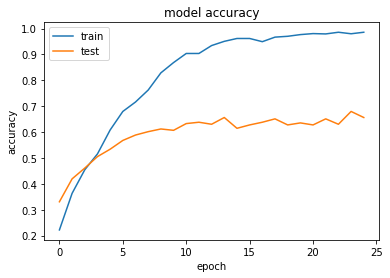

In [680]:
#Plot model accuracy over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [681]:
score = CNN_model.evaluate(x_testcnn, y_test_lb, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

384/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Pre-training accuracy: 65.6250%


In [682]:
# Evaluating the model on the training and testing set
score = CNN_model.evaluate(x_traincnn, y_train_lb, verbose=0)
print("Training Accuracy: ", score[1])

score = CNN_model.evaluate(x_testcnn, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9921875
Testing Accuracy:  0.65625


In [683]:
#Get predictions from model
y_test_predictions = CNN_model.predict_classes(x_testcnn)
y_test_predictions

array([3, 6, 6, 2, 7, 4, 5, 7, 7, 6, 5, 0, 5, 7, 7, 2, 5, 4, 6, 6, 4, 4,
       6, 4, 5, 1, 2, 6, 4, 2, 3, 7, 6, 1, 4, 0, 2, 6, 5, 5, 2, 4, 5, 3,
       7, 1, 6, 6, 7, 3, 7, 5, 3, 1, 0, 4, 4, 4, 4, 3, 4, 7, 3, 7, 7, 7,
       2, 5, 7, 7, 5, 3, 1, 1, 4, 0, 7, 4, 6, 7, 6, 4, 1, 4, 7, 0, 7, 4,
       2, 7, 6, 7, 6, 2, 3, 2, 4, 3, 6, 5, 7, 7, 4, 4, 4, 6, 3, 5, 3, 7,
       3, 3, 5, 5, 7, 2, 3, 4, 1, 7, 3, 7, 0, 3, 0, 5, 3, 7, 2, 6, 5, 6,
       2, 3, 0, 7, 0, 1, 7, 5, 7, 7, 6, 7, 6, 0, 7, 7, 5, 2, 2, 2, 5, 5,
       2, 7, 6, 2, 4, 7, 7, 4, 6, 7, 6, 6, 7, 5, 7, 7, 1, 5, 3, 7, 6, 4,
       3, 6, 7, 7, 6, 7, 6, 1, 4, 0, 4, 6, 4, 7, 1, 3, 7, 7, 3, 3, 4, 6,
       5, 5, 0, 7, 2, 6, 7, 5, 7, 2, 2, 5, 6, 6, 3, 1, 1, 1, 6, 6, 6, 5,
       6, 7, 1, 2, 7, 4, 5, 4, 2, 6, 2, 5, 7, 0, 6, 6, 3, 5, 1, 4, 6, 1,
       2, 1, 3, 1, 3, 3, 0, 3, 6, 5, 0, 5, 4, 1, 3, 0, 2, 5, 7, 6, 4, 3,
       6, 4, 1, 1, 1, 0, 2, 5, 4, 0, 6, 6, 6, 6, 2, 2, 5, 4, 5, 0, 7, 6,
       0, 5, 1, 0, 2, 5, 0, 7, 5, 6, 7, 4, 0, 3, 0,

In [689]:
y_labels_encoded

{0: 'angry',
 1: 'calm',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprised'}

In [690]:
# Change predictions to emotions in order to compare
y_test_predictions_labels =[]

#Go through each prediction and append to new list
for e in range(len(y_test_predictions)):
    y_test_predictions_labels.append(y_labels_encoded[y_test_predictions[e]])
    
#Build array of predictions
y_test_predictions_labels = np.array(y_test_predictions_labels)
y_test_predictions_labels

array(['fear', 'sad', 'sad', 'disgust', 'surprised', 'happy', 'neutral',
       'surprised', 'surprised', 'sad', 'neutral', 'angry', 'neutral',
       'surprised', 'surprised', 'disgust', 'neutral', 'happy', 'sad',
       'sad', 'happy', 'happy', 'sad', 'happy', 'neutral', 'calm',
       'disgust', 'sad', 'happy', 'disgust', 'fear', 'surprised', 'sad',
       'calm', 'happy', 'angry', 'disgust', 'sad', 'neutral', 'neutral',
       'disgust', 'happy', 'neutral', 'fear', 'surprised', 'calm', 'sad',
       'sad', 'surprised', 'fear', 'surprised', 'neutral', 'fear', 'calm',
       'angry', 'happy', 'happy', 'happy', 'happy', 'fear', 'happy',
       'surprised', 'fear', 'surprised', 'surprised', 'surprised',
       'disgust', 'neutral', 'surprised', 'surprised', 'neutral', 'fear',
       'calm', 'calm', 'happy', 'angry', 'surprised', 'happy', 'sad',
       'surprised', 'sad', 'happy', 'calm', 'happy', 'surprised', 'angry',
       'surprised', 'happy', 'disgust', 'surprised', 'sad', 'surpris

In [691]:
from sklearn.metrics import confusion_matrix

#Build confusion matrix and see results
confusion_matrix = confusion_matrix(y_test, y_test_predictions_labels)
confusion_matrix

array([[23,  1,  2,  0,  7,  3,  2,  7],
       [ 0, 23,  0,  1,  0,  4,  6,  1],
       [ 1,  0, 32,  1,  3,  0,  4, 14],
       [ 1,  0,  2, 31,  2,  0,  1,  4],
       [ 3,  3,  1,  5, 28,  2,  0, 14],
       [ 0,  5,  1,  1,  0, 37,  6,  0],
       [ 0,  2,  0,  4,  2,  3, 42,  2],
       [ 0,  0,  2,  3,  5,  0,  1, 36]])

In [692]:
#See confusion matrix shape
confusion_matrix.shape

(8, 8)

In [693]:
#Turn al correct answers into 0 to visualize errors better
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        if i == j:
            confusion_matrix[i,j] = 0

# See results
confusion_matrix

array([[ 0,  1,  2,  0,  7,  3,  2,  7],
       [ 0,  0,  0,  1,  0,  4,  6,  1],
       [ 1,  0,  0,  1,  3,  0,  4, 14],
       [ 1,  0,  2,  0,  2,  0,  1,  4],
       [ 3,  3,  1,  5,  0,  2,  0, 14],
       [ 0,  5,  1,  1,  0,  0,  6,  0],
       [ 0,  2,  0,  4,  2,  3,  0,  2],
       [ 0,  0,  2,  3,  5,  0,  1,  0]])

In [694]:
confusion_matrix = pd.DataFrame(confusion_matrix, columns=list(y_labels_encoded.values()), index=list(y_labels_encoded.values()))

print("The rows represents the true values or observations")
print("The columns respresent the model's predictions")

#Print confusion matrix results
confusion_matrix

The rows represents the true values or observations
The columns respresent the model's predictions


,angry,calm,disgust,fear,happy,neutral,sad,surprised
angry,0,1,2,0,7,3,2,7
calm,0,0,0,1,0,4,6,1
disgust,1,0,0,1,3,0,4,14
fear,1,0,2,0,2,0,1,4
happy,3,3,1,5,0,2,0,14
neutral,0,5,1,1,0,0,6,0
sad,0,2,0,4,2,3,0,2
surprised,0,0,2,3,5,0,1,0


# Save Model

In [684]:
pwd

'/Users/joheunkang/Desktop/FALL2020/DSP/DSP_Project'

In [708]:
model_name = 'new.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/joheunkang/Desktop/FALL2020/DSP/DSP_Project/saved_models/new.h5 


In [709]:
import json
model_json = model.to_json()
with open("model_new.json", "w") as json_file:
    json_file.write(model_json)

__Summary:__ from the above training process, we have saved a model called "emotion_analyzer_final_project" model and its weights. Then, we will apply this model to the real-time program to predict emotion of the voice. 


In [711]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model_new.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/new.h5")
print("Loaded model from disk")

Loaded model from disk


In [713]:
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [714]:
livedf2= pd.DataFrame(data=livedf2)


In [715]:
livedf2

,0
0,-25.438190
1,-22.968264
2,-20.324472
3,-18.562527
4,-20.716328
...,...
211,-21.568727
212,-21.497141
213,-18.807360
214,-19.452421


In [716]:

livedf2 = livedf2.stack().to_frame().T

In [717]:

livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-25.43819,-22.968264,-20.324472,-18.562527,-20.716328,-22.835356,-24.079182,-23.334389,-22.314707,-24.084188,...,-19.915915,-23.057016,-22.750437,-24.055338,-21.781971,-21.568727,-21.497141,-18.80736,-19.452421,-19.316862


In [718]:

twodim= np.expand_dims(livedf2, axis=2)

In [719]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 190ms/step


In [720]:
livepreds

array([[6.7300076e-04, 1.0664248e-03, 1.4104368e-03, 1.8847667e-04,
        1.0691880e-02, 7.5964624e-01, 1.9086023e-01, 3.5463270e-02]],
      dtype=float32)

In [721]:
livepreds1=livepreds.argmax(axis=1)

In [722]:
liveabc = livepreds1.astype(int).flatten()

In [724]:
liveabc

array([5])

In [725]:
y_labels_encoded

{0: 'angry',
 1: 'calm',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprised'}

In [727]:
liveabc

'neutral'